# 导入相关软件包

In [76]:
import os
import random
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, roc_auc_score

In [44]:
# 随机种子
def seed_pytorch(seed, ifDeep=False):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    if(ifDeep):
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU
        torch.backends.cudnn.deterministic = True  # 保证每次结果相同
        torch.backends.cudnn.benchmark = False  # 保证每次结果相同

In [45]:
# # only for test
# current_directory = os.path.dirname(os.path.abspath('__file__'))
# folder_path = '../shared_datasets/MNIST'

# if os.path.exists(folder_path):
#     print("文件夹存在！")
# else:
#     print("文件夹不存在！")
torch.cuda.is_available()

True

# 参数配置

In [95]:
config_para = {
    'data_path':'../shared_datasets/MNIST_IN_CSV/',
    
    'seed':42,
    
    'train':{
        'lr':1e-3,
        'batch_size':32,
        'epochs':30,
    },
    
    'callback':{
                    # 'monitor':'val_acc', # tf才用
                    'patience':10,
                    'save_model_path':'./checkpoints/',
                    },
    
    'MNIST': {
        'conv_kernel_size': 3,
        'pooling_kernel_size': 2,
        'conv_stride': 1,
        'pooling_stride': 2,
        'dropout_rate': 0.5,
    },
}

In [47]:
# seed配置
seed_pytorch(config_para['seed'],ifDeep=True)

In [48]:
config_para['data_path']

'../shared_datasets/MNIST_IN_CSV/'

# 数据读入

In [49]:
# 读入数据

train_data = pd.read_csv(config_para["data_path"]+"mnist_train.csv")
test_data = pd.read_csv(config_para["data_path"]+"mnist_test.csv")

In [50]:
train_data

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
test_data

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 数据预处理与加载

In [52]:
x_trainval = torch.tensor(train_data.drop(["label"], axis=1).to_numpy(), dtype=torch.float32)
y_trainval = torch.tensor(train_data["label"].array.reshape(-1,1).to_numpy(), dtype=torch.long)

x_test = torch.tensor(test_data.drop(["label"], axis=1).to_numpy(), dtype=torch.float32)
y_test = torch.tensor(test_data["label"].array.reshape(-1,1).to_numpy(), dtype=torch.long)

In [53]:
# 额外设置了验证集，三者比例为5:1:1
x_train, x_val, y_train ,y_val = train_test_split(x_trainval, y_trainval, test_size=1/6, random_state=config_para['seed'], shuffle=True)

In [54]:
x_train.shape, x_val.shape, x_test.shape,y_train.shape, y_val.shape, y_test.shape

(torch.Size([50000, 784]),
 torch.Size([10000, 784]),
 torch.Size([10000, 784]),
 torch.Size([50000, 1]),
 torch.Size([10000, 1]),
 torch.Size([10000, 1]))

# 可视化和探索性分析

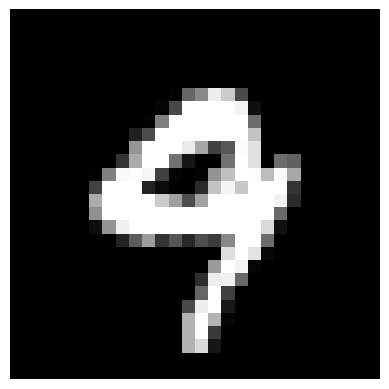

In [55]:
# 随机抽样可视化一下

rand_num = 123
img = x_train[rand_num,:].reshape(28,28)

plt.imshow(img, cmap='gray')
plt.axis("off")
plt.show()

In [56]:
# 查看类别名称和类别数量

class_names = np.unique(y_train)
num_classes = class_names.size
print(class_names, num_classes)

[0 1 2 3 4 5 6 7 8 9] 10


# 模型设置

In [57]:
class MyCNN(nn.Module):
  '''
    模型架构：三个卷积层+全局池化+tanh激活函数，展平连接后接两个全连接层，添加dropout，最后一层softmax输出
  '''
  # 注：MNIST是灰度图像，input_channels设为1
  def __init__(self, input_channels=1, num_classes=10):
      super(MyCNN, self).__init__()
      self.conv_kernel_size = config_para['MNIST']['conv_kernel_size']
      self.pooling_kernel_size = config_para['MNIST']['pooling_kernel_size']
      self.conv_stride = config_para['MNIST']['conv_stride']
      self.pooling_stride = config_para['MNIST']['pooling_stride']
      self.dropout_rate = config_para['MNIST']['dropout_rate']

      # 第一个卷积+池化
      self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=32, kernel_size=self.conv_kernel_size, stride=self.conv_stride, padding=1)
      self.pool1 = nn.MaxPool2d(kernel_size=self.pooling_kernel_size, stride=self.pooling_stride) 

      # 第二个卷积+池化
      self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=self.conv_kernel_size, stride=self.conv_stride, padding=1)
      self.pool2 = nn.MaxPool2d(kernel_size=self.pooling_kernel_size, stride=self.pooling_stride) 

      # 全连接
      self.flatten = nn.Flatten()   # 展平
      self.fc1 = nn.Linear(64 * 7 * 7, 128) # embedding
      self.dropout = nn.Dropout(p=self.dropout_rate)  # Dropout
      self.fc2 = nn.Linear(128, num_classes)
      self.tanh = nn.Tanh()

  def forward(self, x):
      x = self.tanh(self.conv1(x)) # (32,28,28)
      x = self.pool1(x) # (32,14,14)

      x = self.tanh(self.conv2(x)) # (64,14,14)
      x = self.pool2(x) # (64,7,7)

      x = self.flatten(x)
      x = self.tanh(self.fc1(x))
      x = self.dropout(x)
      x = self.fc2(x)
      x = F.softmax(x, dim=1)

      return x

# 模型配置

In [58]:
# 导入训练、验证和测试数据
def get_dataloader(x, y, batch_size, shuffle=True, random=config_para['seed']):
    x = x.reshape(-1, 1, 28, 28)
    dataset = TensorDataset(x, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

train_loader = get_dataloader(x_train, y_train, batch_size=config_para['train']['batch_size'], shuffle=True)
val_loader = get_dataloader(x_val, y_val, batch_size=config_para['train']['batch_size'], shuffle=False)
test_loader = get_dataloader(x_test, y_test, batch_size=config_para['train']['batch_size'], shuffle=False)

In [59]:
# 训练配置

# 模型实例化
model = MyCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config_para['train']['lr'])

# Early Stopping 相关变量
best_val_acc = -float('inf')
patience = config_para['callback']['patience']
# monitor = config_para['callback']['monitor']
early_stop_counter = 0
save_model_path = config_para['callback']['save_model_path']

if not os.path.exists(save_model_path):
    os.makedirs(save_model_path)

In [88]:
# 验证函数
def validate(model, loader):
    model.eval()
    y_true = []
    y_pred = []
    val_loss = 0.0
    
    with torch.no_grad():
        for x_batch, y_batch in loader:
            y_batch = y_batch.squeeze(dim=1)
            outputs = model(x_batch)
            # print(f"Outputs shape: {outputs.shape}, Targets shape: {y_batch.shape}")
            
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, dim=1)  # 取出概率最大的类别
            
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            
    val_loss = val_loss / len(loader)
    val_acc = accuracy_score(y_true, y_pred, normalize=True)
    
    return val_loss, val_acc

In [96]:
# 每个epoch
def train_epoch(model, loader, criterion, optimizer, epoch, total_epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(loader, desc=f"Epoch {epoch}/{total_epochs}", unit="batch", leave=True)  # 进度条

    for x_batch, y_batch in progress_bar:
        y_batch = y_batch.squeeze(dim=1) 
        optimizer.zero_grad()
        outputs = model(x_batch)
        # print(f"Outputs shape: {outputs.shape}, Targets shape: {y_batch.shape}")
        
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # 更新进度条显示的损失
        progress_bar.set_postfix(loss=loss.item())
    return total_loss / len(loader)

# 主循环
def train():
    train_losses = []
    val_losses = []
    val_accs = []
    
    best_val_acc = -float('inf')
    early_stop_counter = 0
    patience = config_para['callback']['patience']

    for epoch in range(1, config_para['train']['epochs'] + 1):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, epoch, config_para['train']['epochs'])
        train_losses.append(train_loss)
        
        val_loss, val_acc = validate(model, val_loader)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch}/{config_para['train']['epochs']}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val ACC: {val_acc:.4f}")

        # Early Stopping 检查
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            early_stop_counter = 0
            torch.save(model.state_dict(), os.path.join(save_model_path, 'best_model.pth'))
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

    return train_losses, val_losses, val_accs

# 训练

In [97]:
train_losses, val_losses, val_accs = train()

Epoch 1/30:   0%|          | 0/1563 [00:00<?, ?batch/s]

Epoch 1/30: 100%|██████████| 1563/1563 [00:27<00:00, 57.16batch/s, loss=1.46]


Epoch 1/30, Train Loss: 1.4827, Val Loss: 1.4769, Val ACC: 0.9849


Epoch 2/30: 100%|██████████| 1563/1563 [00:27<00:00, 56.19batch/s, loss=1.46]


Epoch 2/30, Train Loss: 1.4824, Val Loss: 1.4784, Val ACC: 0.9830


Epoch 3/30: 100%|██████████| 1563/1563 [00:26<00:00, 60.00batch/s, loss=1.46]


Epoch 3/30, Train Loss: 1.4833, Val Loss: 1.4775, Val ACC: 0.9838


Epoch 4/30: 100%|██████████| 1563/1563 [00:25<00:00, 62.34batch/s, loss=1.46]


Epoch 4/30, Train Loss: 1.4837, Val Loss: 1.4769, Val ACC: 0.9850


Epoch 5/30: 100%|██████████| 1563/1563 [00:24<00:00, 63.28batch/s, loss=1.46]


Epoch 5/30, Train Loss: 1.4832, Val Loss: 1.4787, Val ACC: 0.9833


Epoch 6/30: 100%|██████████| 1563/1563 [00:24<00:00, 62.73batch/s, loss=1.46]


Epoch 6/30, Train Loss: 1.4818, Val Loss: 1.4779, Val ACC: 0.9840


Epoch 7/30: 100%|██████████| 1563/1563 [00:26<00:00, 59.55batch/s, loss=1.47]


Epoch 7/30, Train Loss: 1.4834, Val Loss: 1.4788, Val ACC: 0.9823


Epoch 8/30: 100%|██████████| 1563/1563 [00:24<00:00, 63.29batch/s, loss=1.46]


Epoch 8/30, Train Loss: 1.4814, Val Loss: 1.4771, Val ACC: 0.9842


Epoch 9/30: 100%|██████████| 1563/1563 [00:24<00:00, 63.51batch/s, loss=1.47]


Epoch 9/30, Train Loss: 1.4813, Val Loss: 1.4767, Val ACC: 0.9843


Epoch 10/30: 100%|██████████| 1563/1563 [00:23<00:00, 65.53batch/s, loss=1.46]


Epoch 10/30, Train Loss: 1.4829, Val Loss: 1.4779, Val ACC: 0.9836


Epoch 11/30: 100%|██████████| 1563/1563 [00:23<00:00, 65.42batch/s, loss=1.46]


Epoch 11/30, Train Loss: 1.4809, Val Loss: 1.4769, Val ACC: 0.9843


Epoch 12/30: 100%|██████████| 1563/1563 [00:24<00:00, 63.45batch/s, loss=1.46]


Epoch 12/30, Train Loss: 1.4813, Val Loss: 1.4771, Val ACC: 0.9851


Epoch 13/30: 100%|██████████| 1563/1563 [00:23<00:00, 65.14batch/s, loss=1.46]


Epoch 13/30, Train Loss: 1.4815, Val Loss: 1.4768, Val ACC: 0.9846


Epoch 14/30: 100%|██████████| 1563/1563 [00:25<00:00, 60.73batch/s, loss=1.46]


Epoch 14/30, Train Loss: 1.4802, Val Loss: 1.4775, Val ACC: 0.9841


Epoch 15/30: 100%|██████████| 1563/1563 [00:24<00:00, 62.99batch/s, loss=1.46]


Epoch 15/30, Train Loss: 1.4801, Val Loss: 1.4758, Val ACC: 0.9852


Epoch 16/30: 100%|██████████| 1563/1563 [00:24<00:00, 64.63batch/s, loss=1.46]


Epoch 16/30, Train Loss: 1.4804, Val Loss: 1.4763, Val ACC: 0.9852


Epoch 17/30: 100%|██████████| 1563/1563 [00:25<00:00, 61.67batch/s, loss=1.46]


Epoch 17/30, Train Loss: 1.4821, Val Loss: 1.4764, Val ACC: 0.9850


Epoch 18/30: 100%|██████████| 1563/1563 [00:27<00:00, 57.29batch/s, loss=1.48]


Epoch 18/30, Train Loss: 1.4807, Val Loss: 1.4776, Val ACC: 0.9837


Epoch 19/30: 100%|██████████| 1563/1563 [00:25<00:00, 62.36batch/s, loss=1.46]


Epoch 19/30, Train Loss: 1.4806, Val Loss: 1.4771, Val ACC: 0.9844


Epoch 20/30: 100%|██████████| 1563/1563 [00:25<00:00, 62.07batch/s, loss=1.5] 


Epoch 20/30, Train Loss: 1.4810, Val Loss: 1.4773, Val ACC: 0.9840


Epoch 21/30: 100%|██████████| 1563/1563 [00:24<00:00, 63.20batch/s, loss=1.52]


Epoch 21/30, Train Loss: 1.4807, Val Loss: 1.4767, Val ACC: 0.9853


Epoch 22/30: 100%|██████████| 1563/1563 [00:24<00:00, 63.20batch/s, loss=1.46]


Epoch 22/30, Train Loss: 1.4812, Val Loss: 1.4772, Val ACC: 0.9842


Epoch 23/30: 100%|██████████| 1563/1563 [00:26<00:00, 59.61batch/s, loss=1.46]


Epoch 23/30, Train Loss: 1.4813, Val Loss: 1.4756, Val ACC: 0.9857


Epoch 24/30: 100%|██████████| 1563/1563 [00:26<00:00, 58.18batch/s, loss=1.46]


Epoch 24/30, Train Loss: 1.4807, Val Loss: 1.4771, Val ACC: 0.9847


Epoch 25/30: 100%|██████████| 1563/1563 [00:26<00:00, 58.37batch/s, loss=1.46]


Epoch 25/30, Train Loss: 1.4805, Val Loss: 1.4782, Val ACC: 0.9835


Epoch 26/30: 100%|██████████| 1563/1563 [00:29<00:00, 52.12batch/s, loss=1.52]


Epoch 26/30, Train Loss: 1.4798, Val Loss: 1.4783, Val ACC: 0.9825


Epoch 27/30: 100%|██████████| 1563/1563 [00:27<00:00, 56.52batch/s, loss=1.46]


Epoch 27/30, Train Loss: 1.4816, Val Loss: 1.4755, Val ACC: 0.9860


Epoch 28/30: 100%|██████████| 1563/1563 [00:27<00:00, 57.46batch/s, loss=1.52]


Epoch 28/30, Train Loss: 1.4803, Val Loss: 1.4770, Val ACC: 0.9842


Epoch 29/30: 100%|██████████| 1563/1563 [00:28<00:00, 55.71batch/s, loss=1.46]


Epoch 29/30, Train Loss: 1.4799, Val Loss: 1.4763, Val ACC: 0.9852


Epoch 30/30: 100%|██████████| 1563/1563 [00:27<00:00, 56.77batch/s, loss=1.46]


Epoch 30/30, Train Loss: 1.4801, Val Loss: 1.4790, Val ACC: 0.9817


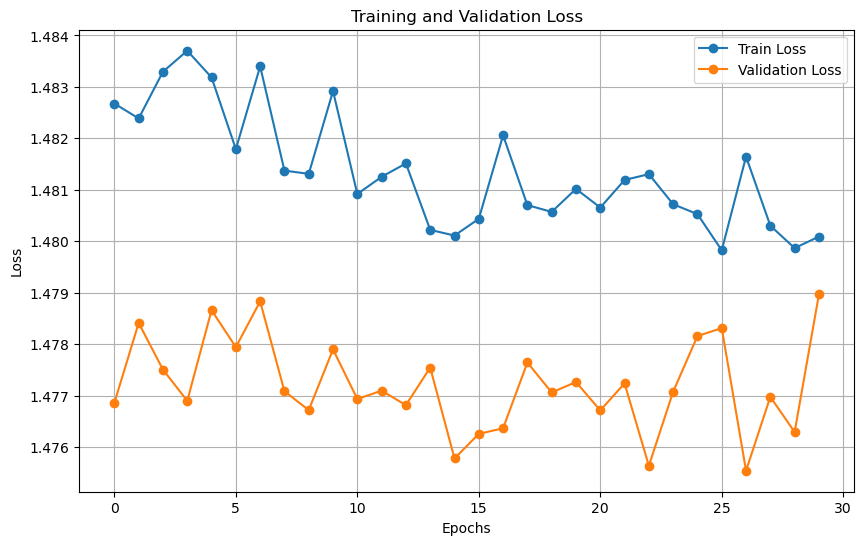

In [98]:
# 绘制训练和验证损失曲线
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Train Loss", marker='o')
    plt.plot(val_losses, label="Validation Loss", marker='o')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
plot_loss(train_losses, val_losses)

# 训练评估与测试

In [104]:
# 测试函数
def test(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x_batch, y_batch in loader:
            y_batch = y_batch.squeeze(dim=1)
            outputs = model(x_batch)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    accuracy = correct / total
    return accuracy

In [105]:
# 测试阶段
model.load_state_dict(torch.load(os.path.join(save_model_path, 'best_model.pth')))
test_accuracy = test(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.4f}")

C:\Users\Jiazhen Huang\AppData\Local\Temp\ipykernel_22960\3055140959.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(save_m

Test Accuracy: 0.9859
